# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


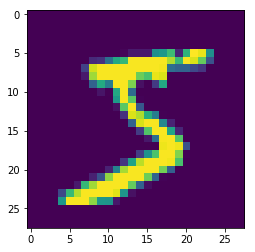

In [3]:
plt.imshow(X_train[0, 0])

In [4]:
input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [5]:
"""
import lasagne
from lasagne.layers import *

#Input layer (auxilary)
l1 = InputLayer(shape = input_shape,input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)
l2 = Conv2DLayer(l1, num_filters=32, filter_size=(5,5), 
                 nonlinearity=lasagne.nonlinearities.rectify, flip_filters=False)
l3 = MaxPool2DLayer(l2, pool_size=(2,2))
l4 = DropoutLayer(l3,  p=0.2)
#l6 = Conv2DLayer(l5, num_filters=8, filter_size=7, pad=1)
#l7 = MaxPool2DLayer(l6, pool_size=2)

l5 = lasagne.layers.DenseLayer(l4, num_units=128, nonlinearity=lasagne.nonlinearities.rectify)

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
l_out = DenseLayer(l5, num_units = 10, nonlinearity=lasagne.nonlinearities.softmax)
"""

'\nimport lasagne\nfrom lasagne.layers import *\n\n#Input layer (auxilary)\nl1 = InputLayer(shape = input_shape,input_var=input_X)\n\n#fully connected layer, that takes input layer and applies 50 neurons to it.\n# nonlinearity here is sigmoid as in logistic regression\n# you can give a name to each layer (optional)\nl2 = Conv2DLayer(l1, num_filters=32, filter_size=(5,5), \n                 nonlinearity=lasagne.nonlinearities.rectify, flip_filters=False)\nl3 = MaxPool2DLayer(l2, pool_size=(2,2))\nl4 = DropoutLayer(l3,  p=0.2)\n#l6 = Conv2DLayer(l5, num_filters=8, filter_size=7, pad=1)\n#l7 = MaxPool2DLayer(l6, pool_size=2)\n\nl5 = lasagne.layers.DenseLayer(l4, num_units=128, nonlinearity=lasagne.nonlinearities.rectify)\n\n#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)\n#We use softmax nonlinearity to make probabilities add up to 1\nl_out = DenseLayer(l5, num_units = 10, nonlinearity=lasagne.nonlinearities.softmax)\n'

In [6]:
import lasagne
from lasagne.layers import *

#Input layer (auxilary)
l1 = InputLayer(shape = input_shape,input_var=input_X)

l2 = Conv2DLayer(l1, num_filters=30, filter_size=(5,5), 
                 nonlinearity=lasagne.nonlinearities.rectify, flip_filters=False)
l3 = MaxPool2DLayer(l2, pool_size=(2,2))
l4 = Conv2DLayer(l3, num_filters=15, filter_size=(3,3), 
                 nonlinearity=lasagne.nonlinearities.rectify, flip_filters=False)
l5 = MaxPool2DLayer(l4, pool_size=(2,2))
l6 = DropoutLayer(l5,  p=0.2)

l7 = lasagne.layers.DenseLayer(l6, num_units=128, nonlinearity=lasagne.nonlinearities.rectify)
l8 = lasagne.layers.DenseLayer(l7, num_units=50, nonlinearity=lasagne.nonlinearities.rectify)

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
l_out = DenseLayer(l8, num_units = 10, nonlinearity=lasagne.nonlinearities.softmax)


In [7]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(l_out)

In [8]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(l_out)
print(all_weights)

[W, b, W, b, W, b, W, b, W, b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [9]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.01)

In [10]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y], [loss,accuracy], updates = updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [11]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

In [12]:
import time

num_epochs = 100 #amount of passes through the data

batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 136.329s
  training loss (in-iteration):		1.041838
  train accuracy:		65.53 %
  validation accuracy:		90.24 %
Epoch 2 of 100 took 142.435s
  training loss (in-iteration):		0.266520
  train accuracy:		91.91 %
  validation accuracy:		94.48 %
Epoch 3 of 100 took 135.503s
  training loss (in-iteration):		0.171922
  train accuracy:		94.63 %
  validation accuracy:		95.90 %
Epoch 4 of 100 took 135.539s
  training loss (in-iteration):		0.133926
  train accuracy:		95.82 %
  validation accuracy:		96.66 %
Epoch 5 of 100 took 146.645s
  training loss (in-iteration):		0.113303
  train accuracy:		96.48 %
  validation accuracy:		96.74 %
Epoch 6 of 100 took 135.721s
  training loss (in-iteration):		0.099592
  train accuracy:		96.87 %
  validation accuracy:		97.12 %
Epoch 7 of 100 took 135.792s
  training loss (in-iteration):		0.090538
  train accuracy:		97.14 %
  validation accuracy:		97.46 %
Epoch 8 of 100 took 135.718s
  training loss (in-iteration):		0.083499
  train accuracy:		

In [14]:
import time

num_epochs = 10 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 223.523s
  training loss (in-iteration):		0.014866
  train accuracy:		99.52 %
  validation accuracy:		98.87 %
Epoch 2 of 10 took 136.817s
  training loss (in-iteration):		0.014017
  train accuracy:		99.50 %
  validation accuracy:		98.87 %
Epoch 3 of 10 took 140.640s
  training loss (in-iteration):		0.015053
  train accuracy:		99.50 %
  validation accuracy:		98.97 %
Epoch 4 of 10 took 136.246s
  training loss (in-iteration):		0.014065
  train accuracy:		99.53 %
  validation accuracy:		98.78 %
Epoch 5 of 10 took 135.899s
  training loss (in-iteration):		0.014379
  train accuracy:		99.50 %
  validation accuracy:		98.87 %
Epoch 6 of 10 took 135.482s
  training loss (in-iteration):		0.014802
  train accuracy:		99.50 %
  validation accuracy:		98.90 %
Epoch 7 of 10 took 134.996s
  training loss (in-iteration):		0.012509
  train accuracy:		99.62 %
  validation accuracy:		98.76 %
Epoch 8 of 10 took 135.819s
  training loss (in-iteration):		0.014739
  train accuracy:		99.50 %


In [15]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
  test accuracy:		99.01 %
Achievement unlocked: 80lvl Warlock!


# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!